In [2]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1) 데이터 준비 (한글)

In [3]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

** data_loader ** 
데이터의 중복 제거
NaN 결측치 제거
한국어 토크나이저로 토큰화
불용어(Stopwords) 제거
사전word_to_index 구성
텍스트 스트링을 사전 인덱스 스트링으로 변환
X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

# Mecab : 형태소 분석기
#         형태소 추출(morphs), 명사 추출, 형태소와 태그 추출 
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)

def load_data(train_data, test_data, num_words=10000):
   
    # document part에서, 중보 제거 및 null 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    
    # Mecab 형태소 분석기를 사용해서, 형태소 추출(morphs)
    x_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_train.append(temp_X)

    x_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        x_test.append(temp_X)
    
    # 빈도수가 높은 순으로 vocabulary를 만들자. 
    # 1) Flattens the list of words
    words = np.concatenate(x_train).tolist()
    
    # 2) Counts word frequencies and gets the top num_words - 4
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    
    # 3) Vocabulary Indexing (0~3 : reserved)
    # word_to_index["<PAD>"] = 0
    # word_to_index["<BOS>"] = 1
    # word_to_index["<UNK>"] = 2  # unknown
    # word_to_index["<UNUSED>"] = 3
    # 자준 나온 단어들 순서대로 word_to_index 구성
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    
    # X_train의 단어들을 vaca_index 값으로 변경
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, x_train))
    X_test = list(map(wordlist_to_indexlist, x_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [5]:
# index to word
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 데이터 분석 및 가공

데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [7]:
# 전체 문장
total_data_text = list(X_train) + list(X_test)
print(len(total_data_text) )

# 한 문장의 길이를  num_tokens에 저장
num_tokens = [len(tokens) for tokens in total_data_text]
# array로 변환
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

195339
문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre' 'post'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre' 'post'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## 4) 모델 구성 및 validation set 구성

In [9]:
# validation set 30000건 분리
x_val = X_train[:70000]   
y_val = y_train[:70000]

# validation set을 제외한 나머지 
partial_x_train = X_train[70000:]  
partial_y_train = y_train[70000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(76182, 41)
(76182,)


**LSTM Model**

In [10]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(32))   
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 166,545
Trainable params: 166,545
Non-trainable params: 0
_________________________________________________________________


**GlobalMaxPooling1D() 레이어**

In [11]:
model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


**1D Convolution Layer**

In [12]:
model_1dcov = tf.keras.Sequential()
model_1dcov.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dcov.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))  # filter size : 7개, 차원수는 16
model_1dcov.add(tf.keras.layers.MaxPooling1D(5))
model_1dcov.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model_1dcov.add(tf.keras.layers.GlobalMaxPooling1D())
model_1dcov.add(tf.keras.layers.Dense(8, activation='relu'))
model_1dcov.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1dcov.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          3616      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [13]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)


Epoch 1/20
149/149 [==============================] - 45s 10ms/step - loss: 0.5775 - accuracy: 0.7050 - val_loss: 0.4359 - val_accuracy: 0.8190
Epoch 2/20
149/149 [==============================] - 1s 7ms/step - loss: 0.3667 - accuracy: 0.8461 - val_loss: 0.3650 - val_accuracy: 0.8422
Epoch 3/20
149/149 [==============================] - 1s 7ms/step - loss: 0.3214 - accuracy: 0.8673 - val_loss: 0.3569 - val_accuracy: 0.8461
Epoch 4/20
149/149 [==============================] - 1s 7ms/step - loss: 0.3023 - accuracy: 0.8762 - val_loss: 0.3609 - val_accuracy: 0.8450
Epoch 5/20
149/149 [==============================] - 1s 7ms/step - loss: 0.2862 - accuracy: 0.8851 - val_loss: 0.3660 - val_accuracy: 0.8443
Epoch 6/20
149/149 [==============================] - 1s 7ms/step - loss: 0.2730 - accuracy: 0.8916 - val_loss: 0.3758 - val_accuracy: 0.8431
Epoch 7/20
149/149 [==============================] - 1s 7ms/step - loss: 0.2592 - accuracy: 0.8988 - val_loss: 0.3821 - val_accuracy: 0.8412
Epoc

In [14]:
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp = model_gmp.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
149/149 [==============================] - 1s 5ms/step - loss: 0.6438 - accuracy: 0.7411 - val_loss: 0.5514 - val_accuracy: 0.7854
Epoch 2/20
149/149 [==============================] - 1s 4ms/step - loss: 0.4586 - accuracy: 0.8168 - val_loss: 0.4054 - val_accuracy: 0.8245
Epoch 3/20
149/149 [==============================] - 1s 4ms/step - loss: 0.3622 - accuracy: 0.8475 - val_loss: 0.3724 - val_accuracy: 0.8366
Epoch 4/20
149/149 [==============================] - 1s 4ms/step - loss: 0.3206 - accuracy: 0.8648 - val_loss: 0.3629 - val_accuracy: 0.8400
Epoch 5/20
149/149 [==============================] - 1s 4ms/step - loss: 0.2927 - accuracy: 0.8789 - val_loss: 0.3624 - val_accuracy: 0.8418
Epoch 6/20
149/149 [==============================] - 1s 4ms/step - loss: 0.2708 - accuracy: 0.8900 - val_loss: 0.3663 - val_accuracy: 0.8410
Epoch 7/20
149/149 [==============================] - 1s 4ms/step - loss: 0.2525 - accuracy: 0.8980 - val_loss: 0.3725 - val_accuracy: 0.8409
Epoch 

In [15]:
model_1dcov.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_1dconv = model_1dcov.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
149/149 [==============================] - 27s 9ms/step - loss: 0.5771 - accuracy: 0.6751 - val_loss: 0.3831 - val_accuracy: 0.8320
Epoch 2/20
149/149 [==============================] - 1s 6ms/step - loss: 0.3466 - accuracy: 0.8504 - val_loss: 0.3549 - val_accuracy: 0.8451
Epoch 3/20
149/149 [==============================] - 1s 6ms/step - loss: 0.3044 - accuracy: 0.8717 - val_loss: 0.3549 - val_accuracy: 0.8470
Epoch 4/20
149/149 [==============================] - 1s 6ms/step - loss: 0.2771 - accuracy: 0.8857 - val_loss: 0.3585 - val_accuracy: 0.8475
Epoch 5/20
149/149 [==============================] - 1s 6ms/step - loss: 0.2531 - accuracy: 0.8982 - val_loss: 0.3665 - val_accuracy: 0.8464
Epoch 6/20
149/149 [==============================] - 1s 6ms/step - loss: 0.2272 - accuracy: 0.9112 - val_loss: 0.3808 - val_accuracy: 0.8447
Epoch 7/20
149/149 [==============================] - 1s 6ms/step - loss: 0.2009 - accuracy: 0.9253 - val_loss: 0.4238 - val_accuracy: 0.8386
Epoch

In [16]:
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results_lstm)

1537/1537 - 3s - loss: 0.6221 - accuracy: 0.8215
[0.622064471244812, 0.8214903473854065]


In [17]:
results_gmp = model_gmp.evaluate(X_test,  y_test, verbose=2)

print(results_gmp)

1537/1537 - 2s - loss: 0.5516 - accuracy: 0.8202
[0.5515815615653992, 0.820208728313446]


In [18]:
results_1dconv = model_1dcov.evaluate(X_test,  y_test, verbose=2)

print(results_1dconv)

1537/1537 - 2s - loss: 0.9918 - accuracy: 0.8134
[0.9917803406715393, 0.8134344816207886]


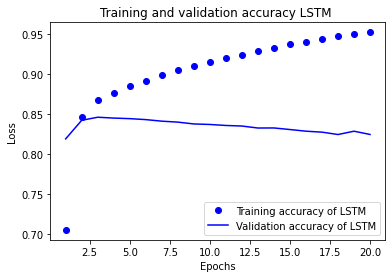

In [19]:
import matplotlib.pyplot as plt

history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training accuracy of LSTM')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy of LSTM')
plt.title('Training and validation accuracy LSTM ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

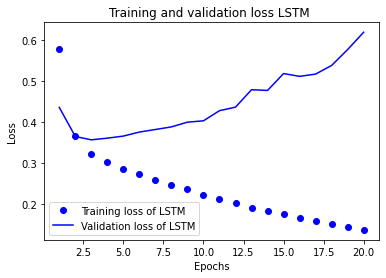

In [20]:
plt.clf()   # 그림을 초기화합니다

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss of LSTM')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss of LSTM')
plt.title('Training and validation loss LSTM ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

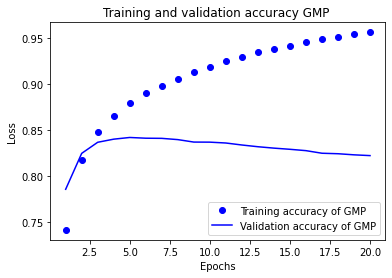

In [21]:
plt.clf()   # 그림을 초기화합니다

history_dict = history_gmp.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training accuracy of GMP')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy of GMP')
plt.title('Training and validation accuracy GMP ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

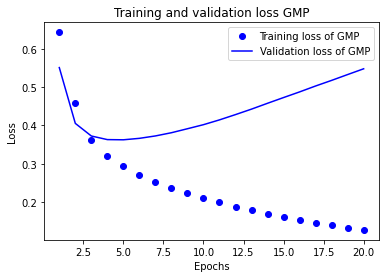

In [22]:
plt.clf()   # 그림을 초기화합니다

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss of GMP')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss of GMP')
plt.title('Training and validation loss GMP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

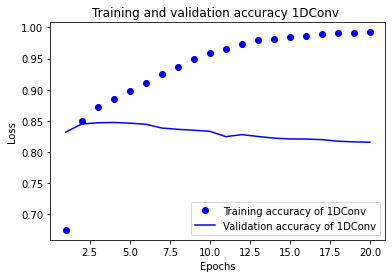

In [23]:
plt.clf()   # 그림을 초기화합니다

history_dict = history_1dconv.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training accuracy of 1DConv')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy of 1DConv')
plt.title('Training and validation accuracy 1DConv ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

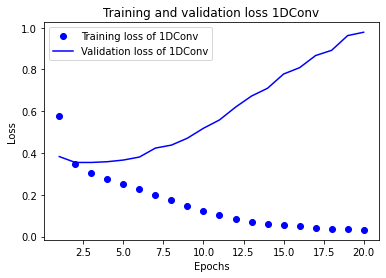

In [24]:
plt.clf()   # 그림을 초기화합니다

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss of 1DConv')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss of 1DConv')
plt.title('Training and validation loss 1DConv')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 회고
훈련 데이타의 성능은 1DConv > GMP > LSTM 이었으나
테스트 데이타의 성능은 LSTM > GMP > 1DConv 순이었다. 

## 7) 학습된 Embedding 레이어 분석

In [25]:
import os

embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_kor.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 16)


In [26]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)


In [27]:
word_vectors.similar_by_word("배우")

[('c', 0.7156264185905457),
 ('감상', 0.7114855647087097),
 ('본성', 0.6752042770385742),
 ('만화', 0.6682097315788269),
 ('넘쳐나', 0.6476684808731079),
 ('라라', 0.6385300159454346),
 ('택시', 0.6384759545326233),
 ('는데요', 0.6323755383491516),
 ('야지', 0.6283780932426453),
 ('똥폼', 0.6274725794792175)]

In [28]:
word_vectors.similar_by_word("실망")

[('떨어지', 0.9614725708961487),
 ('구조', 0.958461344242096),
 ('대충', 0.957857072353363),
 ('쓰레기', 0.955694317817688),
 ('욕', 0.9540031552314758),
 ('차라리', 0.9512563347816467),
 ('삼류', 0.9487443566322327),
 ('재미없', 0.9487111568450928),
 ('식상', 0.9435437917709351),
 ('싫', 0.94211745262146)]

In [29]:
len(word_vectors.index_to_key)

9996

## 회고 : embeding 데이타의 유사성이 거의 없다

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용
한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요

/workspace/gcs/gcp_files/E-9/data

In [30]:
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

#word2vec_file_path = os.getenv('HOME')+'/aiffel/data/word2vec_ko.model'
word2vec_file_path = '/aiffel/data/word2vec_ko.model'
pre_word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)


In [31]:
pre_word_vectors.vector_size

100

In [32]:
len(pre_word_vectors.wv.index_to_key)

302960

In [33]:
vector = pre_word_vectors.wv['영화']
# vector  # 5*20 = 100dim 워드 벡터
vector.shape

(100,)

In [34]:
pre_word_vectors.wv.most_similar("배우")

[('가수', 0.7729029655456543),
 ('코미디언', 0.7728644609451294),
 ('만화가', 0.749615490436554),
 ('영화배우', 0.7441834211349487),
 ('여배우', 0.7411354184150696),
 ('연출가', 0.7396705746650696),
 ('극작가', 0.7209770679473877),
 ('삽화가', 0.7152643799781799),
 ('안무가', 0.7149248123168945),
 ('무용가', 0.7118033766746521)]

In [35]:
pre_word_vectors.wv.most_similar("실망")

[('당황', 0.8200313448905945),
 ('당혹', 0.8075222373008728),
 ('곤혹', 0.771090030670166),
 ('낙담', 0.7601173520088196),
 ('분개', 0.7536212205886841),
 ('경악', 0.7477779984474182),
 ('뻔뻔', 0.7368745803833008),
 ('격분', 0.733599066734314),
 ('감탄', 0.7275494337081909),
 ('분노', 0.7243137955665588)]

## 회고
1) 단어의 유사성 비교 
   embedding layer로 훈련한 데이타의 유사성은 (배우, 실망) 두 단어에 대해서 유사성이 낮은 단어들이 출력되었고,  
   pre-trained 벡터에서 (배우, 실망) 두 단어에 대해서 유사성이 높은 단어들이 출력되었다. 
2) 유사성 성능 차이로 생각되는 이유  
   embeding layer로 훈련한 데이타는 갯수가 10000개(9996)개로 사이즈가 적고, 
   pre-trained data 는 30만개로 사이즈가 크다
   또한, pre-trained는 여러번 다양한 단어들(토큰들)로 테스트를 여러번 누적된 데이타이므로, 벡터화가 잘 되어서, 성능이 좋다. 

In [36]:

pre_word_vector_dim = pre_word_vectors.vector_size  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, pre_word_vector_dim)

print(embedding_matrix.shape)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in pre_word_vectors.wv:
        embedding_matrix[i] = pre_word_vectors.wv[index_to_word[i]]

(10000, 100)


In [37]:
from tensorflow.keras.initializers import Constant
from tensorflow import keras
from tensorflow.keras import layers

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 pre_word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 32)            22432     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 32)             7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [38]:
# 학습의 진행
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_lstm.h5",
                                    save_best_only=True)
]

history_pre = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1, 
                    callbacks=callbacks)


Epoch 1/10
149/149 [==============================] - 2s 9ms/step - loss: 0.6124 - accuracy: 0.6573 - val_loss: 0.5370 - val_accuracy: 0.7313
Epoch 2/10
149/149 [==============================] - 1s 7ms/step - loss: 0.5096 - accuracy: 0.7510 - val_loss: 0.4904 - val_accuracy: 0.7643
Epoch 3/10
149/149 [==============================] - 1s 7ms/step - loss: 0.4565 - accuracy: 0.7861 - val_loss: 0.4526 - val_accuracy: 0.7901
Epoch 4/10
149/149 [==============================] - 1s 7ms/step - loss: 0.4165 - accuracy: 0.8100 - val_loss: 0.4272 - val_accuracy: 0.8048
Epoch 5/10
149/149 [==============================] - 1s 7ms/step - loss: 0.3843 - accuracy: 0.8283 - val_loss: 0.4136 - val_accuracy: 0.8143
Epoch 6/10
149/149 [==============================] - 1s 7ms/step - loss: 0.3593 - accuracy: 0.8400 - val_loss: 0.4183 - val_accuracy: 0.8134
Epoch 7/10
149/149 [==============================] - 1s 6ms/step - loss: 0.3341 - accuracy: 0.8539 - val_loss: 0.4653 - val_accuracy: 0.7933
Epoch 

In [39]:
results_pre = model.evaluate(X_test,  y_test, verbose=2)

print(results_pre)

1537/1537 - 3s - loss: 0.4202 - accuracy: 0.8200
[0.42022714018821716, 0.8200052976608276]


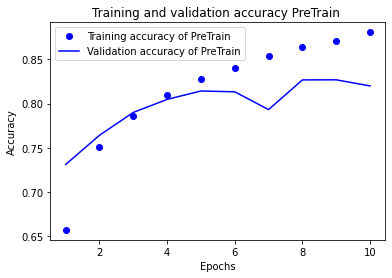

In [40]:
history_dict = history_pre.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training accuracy of PreTrain')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy of PreTrain')
plt.title('Training and validation accuracy PreTrain ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

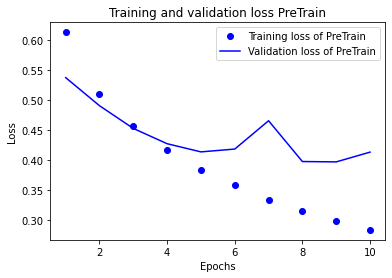

In [41]:
plt.clf()   # 그림을 초기화합니다

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss of PreTrain')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss of PreTrain')
plt.title('Training and validation loss PreTrain')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [61]:

# 모델 구성
model_pre = tf.keras.Sequential()
model_pre.add(tf.keras.layers.Embedding(vocab_size, 
                                 pre_word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_pre.add(tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(32) ))   
model_pre.add(tf.keras.layers.Dropout(0.5))
model_pre.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model_pre.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 1,034,113
Trainable params: 1,034,113
Non-trainable params: 0
_________________________________________________________________


In [62]:
# 학습의 진행
model_pre.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_lstm.h5",
                                    save_best_only=True)
]

history_pre = model_pre.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1, 
                    callbacks=callbacks)


Epoch 1/20
149/149 [==============================] - 5s 15ms/step - loss: 0.5856 - accuracy: 0.6857 - val_loss: 0.4864 - val_accuracy: 0.7703
Epoch 2/20
149/149 [==============================] - 2s 11ms/step - loss: 0.4725 - accuracy: 0.7817 - val_loss: 0.4266 - val_accuracy: 0.8088
Epoch 3/20
149/149 [==============================] - 2s 11ms/step - loss: 0.4230 - accuracy: 0.8108 - val_loss: 0.4024 - val_accuracy: 0.8202
Epoch 4/20
149/149 [==============================] - 2s 11ms/step - loss: 0.3886 - accuracy: 0.8287 - val_loss: 0.3732 - val_accuracy: 0.8357
Epoch 5/20
149/149 [==============================] - 2s 11ms/step - loss: 0.3645 - accuracy: 0.8423 - val_loss: 0.3633 - val_accuracy: 0.8411
Epoch 6/20
149/149 [==============================] - 2s 11ms/step - loss: 0.3437 - accuracy: 0.8527 - val_loss: 0.3554 - val_accuracy: 0.8437
Epoch 7/20
149/149 [==============================] - 2s 11ms/step - loss: 0.3290 - accuracy: 0.8609 - val_loss: 0.3466 - val_accuracy: 0.8491

In [63]:
#model = keras.models.load_model("embeddings_bidir_lstm.h5")
results_pre2 = model_pre.evaluate(X_test,  y_test, verbose=2)

print(results_pre2)

1537/1537 - 4s - loss: 0.3717 - accuracy: 0.8540
[0.37169960141181946, 0.8539780974388123]


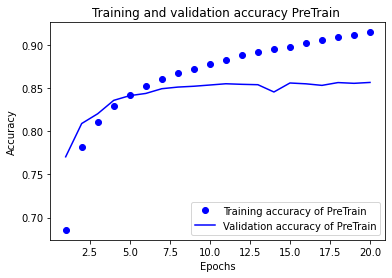

In [64]:
history_dict = history_pre.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training accuracy of PreTrain')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy of PreTrain')
plt.title('Training and validation accuracy PreTrain ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 회고 
Bidirectional 방식으로 accuracy 85.4% 도달하였음